# Modelo de Minimização de Autômato Deterministico
---

## Importações

In [1]:
import sys
from pathlib import Path
sys.path.append(str(Path("../src/").resolve()))
from desenhar_automatos import desenhar_afd

# Conversão: Minimização de Autômato</a>


# Modelo em JSON <a id="automato-json"></a>

- Modelo em formato **JSON**:


In [2]:
automato_input = {
  "estados": ["q0", "q1", "q2", "q3", "q4", "q5"],
  "alfabeto": ["a", "b"],
  "estado_inicial": "q0",
  "estados_finais": ["q3"],
  "transicoes": {
    "q0": {"a": "q1", "b": "q2"},
    "q1": {"a": "q3", "b": "q4"},
    "q2": {"a": "q3", "b": "q4"},
    "q3": {"a": "q3", "b": "q3"},
    "q4": {"a": "q4", "b": "q4"},
    "q5": {"a": "q0", "b": "q1"}
  }
}

- Modelo ilustrado:

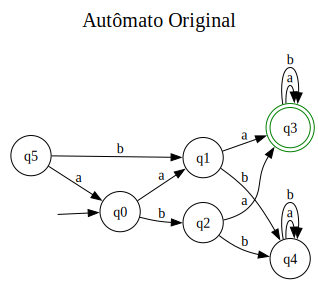

In [3]:
desenhar_afd(automato_input, "Autômato Original")

# Minimização

# PASSO A: Construir Tabela (Pares Distintos)
- Representaremos a tabela como um dicionário de pares (u, v) -> marcado?
- Consideramos apenas u < v para evitar duplicatas (q0,q1 é igual a q1,q0)

In [4]:
estados = sorted(automato_input['estados'])
finais = set(automato_input['estados_finais'])
transicoes = automato_input['transicoes']
alfabeto = automato_input['alfabeto']

In [5]:
tabela = {}
pares = []
for i in range(len(estados)):
    for j in range(i + 1, len(estados)):
        u, v = estados[i], estados[j]
        tabela[(u, v)] = False
        pares.append((u, v))

In [6]:
tabela

{('q0', 'q1'): False,
 ('q0', 'q2'): False,
 ('q0', 'q3'): False,
 ('q0', 'q4'): False,
 ('q0', 'q5'): False,
 ('q1', 'q2'): False,
 ('q1', 'q3'): False,
 ('q1', 'q4'): False,
 ('q1', 'q5'): False,
 ('q2', 'q3'): False,
 ('q2', 'q4'): False,
 ('q2', 'q5'): False,
 ('q3', 'q4'): False,
 ('q3', 'q5'): False,
 ('q4', 'q5'): False}

# PASSO B: Marcação Trivial (Final vs Não-Final)
- Marcar todos os pares do tipo {estado final, estado não-final}

In [7]:
for (u, v) in pares:
    u_final = u in finais
    v_final = v in finais
    if u_final != v_final:
        tabela[(u, v)] = True

In [8]:
tabela

{('q0', 'q1'): False,
 ('q0', 'q2'): False,
 ('q0', 'q3'): True,
 ('q0', 'q4'): False,
 ('q0', 'q5'): False,
 ('q1', 'q2'): False,
 ('q1', 'q3'): True,
 ('q1', 'q4'): False,
 ('q1', 'q5'): False,
 ('q2', 'q3'): True,
 ('q2', 'q4'): False,
 ('q2', 'q5'): False,
 ('q3', 'q4'): True,
 ('q3', 'q5'): True,
 ('q4', 'q5'): False}

# PASSO C: Marcação dos estados não-equivalentes (Iterativo)
- Para cada par {qu, qv} não marcado... e para cada símbolo... se atingem par marcado, marque

In [9]:
mudou = True
while mudou:
    mudou = False
    for (u, v) in pares:
        if not tabela[(u, v)]:
            for simbolo in alfabeto:
                dest_u = transicoes.get(u, {}).get(simbolo)
                dest_v = transicoes.get(v, {}).get(simbolo)

                if dest_u and dest_v and dest_u != dest_v:
                    p_dest = tuple(sorted((dest_u, dest_v)))
                      
                    if tabela.get(p_dest, False):
                        tabela[(u, v)] = True
                        mudou = True
                        break 

In [10]:
tabela

{('q0', 'q1'): True,
 ('q0', 'q2'): True,
 ('q0', 'q3'): True,
 ('q0', 'q4'): True,
 ('q0', 'q5'): True,
 ('q1', 'q2'): False,
 ('q1', 'q3'): True,
 ('q1', 'q4'): True,
 ('q1', 'q5'): True,
 ('q2', 'q3'): True,
 ('q2', 'q4'): True,
 ('q2', 'q5'): True,
 ('q3', 'q4'): True,
 ('q3', 'q5'): True,
 ('q4', 'q5'): True}

# PASSO D: Unificação dos estados equivalentes
- "Os estados dos pares não-marcados são equivalentes e podem ser unificados"
- Vamos usar Union-Find ou Busca em Componentes para agrupar

In [11]:
def find(n):
    if parent[n] != n: parent[n] = find(parent[n])
    return parent[n]
    
def union(n1, n2):
    root1, root2 = find(n1), find(n2)
    if root1 != root2: parent[root2] = root1

In [12]:
parent = {e: e for e in estados}
parent

{'q0': 'q0', 'q1': 'q1', 'q2': 'q2', 'q3': 'q3', 'q4': 'q4', 'q5': 'q5'}

In [13]:
for (u, v), marcado in tabela.items():
    if not marcado:
        union(u, v)
parent

{'q0': 'q0', 'q1': 'q1', 'q2': 'q1', 'q3': 'q3', 'q4': 'q4', 'q5': 'q5'}

In [14]:
grupos = {}
for e in estados:
    root = find(e)
    grupos.setdefault(root, []).append(e)

grupos

{'q0': ['q0'], 'q1': ['q1', 'q2'], 'q3': ['q3'], 'q4': ['q4'], 'q5': ['q5']}

In [15]:
mapa_nomes = {e: "_".join(sorted(lista)) for root, lista in grupos.items() for e in lista}
mapa_nomes

{'q0': 'q0', 'q1': 'q1_q2', 'q2': 'q1_q2', 'q3': 'q3', 'q4': 'q4', 'q5': 'q5'}

In [16]:
novos_estados = sorted(list(set(mapa_nomes.values())))
novo_inicial = mapa_nomes[automato_input['estado_inicial']]
novos_finais = sorted(list(set(mapa_nomes[e] for e in finais)))

print(novos_estados)
print(novo_inicial)
print(novos_finais)

['q0', 'q1_q2', 'q3', 'q4', 'q5']
q0
['q3']


In [17]:
novas_transicoes = {}
for root, lista in grupos.items():
    rep = lista[0]
    nome_grupo = mapa_nomes[rep]
    novas_transicoes[nome_grupo] = {}
    for s in alfabeto:
        destino_original = transicoes.get(rep, {}).get(s)
        if destino_original:
            novas_transicoes[nome_grupo][s] = mapa_nomes[destino_original]

afd_unificado = {
    "estados": novos_estados,
    "alfabeto": alfabeto,
    "estado_inicial": novo_inicial,
    "estados_finais": novos_finais,
    "transicoes": novas_transicoes
}

afd_unificado

{'estados': ['q0', 'q1_q2', 'q3', 'q4', 'q5'],
 'alfabeto': ['a', 'b'],
 'estado_inicial': 'q0',
 'estados_finais': ['q3'],
 'transicoes': {'q0': {'a': 'q1_q2', 'b': 'q1_q2'},
  'q1_q2': {'a': 'q3', 'b': 'q4'},
  'q3': {'a': 'q3', 'b': 'q3'},
  'q4': {'a': 'q4', 'b': 'q4'},
  'q5': {'a': 'q0', 'b': 'q1_q2'}}}

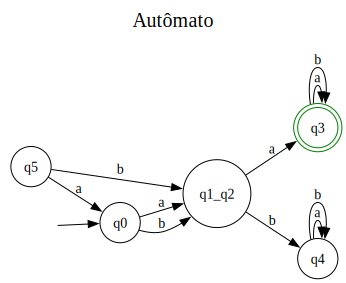

In [18]:
desenhar_afd(afd_unificado)

# PASSO E: Exclusão dos estados inúteis 
- O texto define inútil como: "não-final e a partir de q não é possível atingir final" (Estado Morto)
- E também implica inalcançáveis a partir do inicial.

In [19]:
alcancaveis = set()
fila = [afd_unificado['estado_inicial']]
while fila:
    curr = fila.pop(0)
    if curr not in alcancaveis:
        alcancaveis.add(curr)
        for s in alfabeto:
            prox = afd_unificado['transicoes'].get(curr, {}).get(s)
            if prox: fila.append(prox)

alcancaveis

{'q0', 'q1_q2', 'q3', 'q4'}

In [20]:
reverso = {e: [] for e in afd_unificado['estados']}
for orig, trans in afd_unificado['transicoes'].items():
    for s, dest in trans.items():
        if dest in reverso: reverso[dest].append(orig)

reverso

{'q0': ['q5'],
 'q1_q2': ['q0', 'q0', 'q5'],
 'q3': ['q1_q2', 'q3', 'q3'],
 'q4': ['q1_q2', 'q4', 'q4'],
 'q5': []}

In [21]:
vivos = set()
fila_vivos = [e for e in afd_unificado['estados_finais']] 
visited_vivos = set(fila_vivos)

visited_vivos

{'q3'}

In [22]:
while fila_vivos:
    curr = fila_vivos.pop(0)
    vivos.add(curr)
    for pai in reverso.get(curr, []):
        if pai not in visited_vivos:
            visited_vivos.add(pai)
            fila_vivos.append(pai)

estados_uteis = sorted([e for e in alcancaveis if e in vivos])
estados_uteis

['q0', 'q1_q2', 'q3']

In [23]:
trans_final = {
    e: {s: d for s, d in afd_unificado['transicoes'][e].items() if d in estados_uteis}
    for e in estados_uteis
}

trans_final

{'q0': {'a': 'q1_q2', 'b': 'q1_q2'},
 'q1_q2': {'a': 'q3'},
 'q3': {'a': 'q3', 'b': 'q3'}}

In [24]:
automato_minimizado = {
    "estados": estados_uteis,
    "alfabeto": alfabeto,
    "estado_inicial": novo_inicial if novo_inicial in estados_uteis else None,
    "estados_finais": [e for e in novos_finais if e in estados_uteis],
    "transicoes": trans_final
}

automato_minimizado

{'estados': ['q0', 'q1_q2', 'q3'],
 'alfabeto': ['a', 'b'],
 'estado_inicial': 'q0',
 'estados_finais': ['q3'],
 'transicoes': {'q0': {'a': 'q1_q2', 'b': 'q1_q2'},
  'q1_q2': {'a': 'q3'},
  'q3': {'a': 'q3', 'b': 'q3'}}}

# Resultado

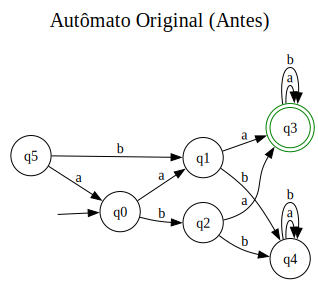

In [25]:
desenhar_afd(automato_input, "Autômato Original (Antes)")

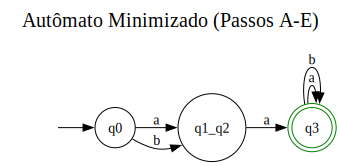

In [26]:
desenhar_afd(automato_minimizado, "Autômato Minimizado (Passos A-E)")